# Introduction

In this notebook I build several Recurrent Neural Networks (RNNs), using Keras, to classify records from the Disaster Tweets dataset: Using Tweet text and meta data, predict whether or not the Tweet refers to a real disaster. I experiment with four model architectures, including simple RNN, LSTM, and GRU layers, with a top leaderboard score of 79.31%.

The models in this notebook utilize only the text of each Tweet, plus the keyword field, to learn the data and make predictions. The text are preprocessed (URLs and special characters are removed), tokenized, and then fed through a vectorization layer, with a vocabulary built using a scikit-learn TfidfVectorizer, before being passed into the model for training.

The notebook progresses in the following manner: Preliminaries and set up; Data exploration, sampling; Model architecture, plan; Model training; Analysis and conclusion.

GitHub location: https://github.com/beha9089/DTSA5511_Wk4_NLP/blob/main/disaster-tweets-nlp.ipynb

# Preliminaries and Setup
Here I will take care of imports and reading in the data. All package/library imports are done here.

In [39]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

The competition overview stated 10K tweets but there are 10,876 tweets across both train and test. There is a 30% train/test split.

In [2]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

print(f'train_df has shape {train_df.shape}')
print(f'test_df has shape {test_df.shape}')

train_df has shape (7613, 5)
test_df has shape (3263, 4)


In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Data Exploration
While the competition notes state that there are 10K Tweets, that is the entire dataset and only about 70% is available for training and validation. There are 7,613 records for training. However, there are some duplicate records, 52, that will be removed before moving forward. 

In this section I perform some basic EDA and clean up of the data. In addition to remove duplicate records and chucking out the id column, I: replace the NA values in location and keyword; look at the presence of location/keyword by target; compare top keywords by target; check the balance of target; clean up the text field, including adding keyword to it; and look at some descriptive statistics of word and charcter counts, by target.

In [4]:
# Right away I will drop the id column
train_df.drop(columns = 'id', inplace = True)

# Drop duplicates
print(f'There are {np.sum(train_df.duplicated())} duplicate records')
train_df.drop_duplicates(inplace = True)
train_df.reset_index(inplace = True)

There are 52 duplicate records


Below I fill in the NA values in location and keyword and create indicator columns for both. I do this for both train and test. 

In [5]:
# Fill the NAs
train_df['location'].fillna('Unknown', inplace = True)
train_df['keyword'].fillna('Unknown', inplace = True)

# Re-insert the space back into keyword
train_df['keyword'] = train_df['keyword'].str.replace('%20', ' ')

# Create an indicator
train_df['has_keyword'] = (train_df.keyword != 'Unknown').astype('int')
train_df['has_location'] = (train_df.location != 'Unknown').astype('int')

## Repeat the above for test
# Fill the NAs
test_df['location'].fillna('Unknown', inplace = True)
test_df['keyword'].fillna('Unknown', inplace = True)
# Re-insert the space back into keyword
test_df['keyword'] = test_df['keyword'].str.replace('%20', ' ')
# Create an indicator
test_df['has_keyword'] = (test_df.keyword != 'Unknown').astype('int')
test_df['has_location'] = (test_df.location != 'Unknown').astype('int')

The below indicates there is a difference small difference between the target values in the proportion of records with a non-null keyword or location. Further, note the fact that approximately 1/3 of records lack a location.

In [6]:
print('Proportion of records with has_keywords == 1 by target:')
print(train_df.groupby('target')['has_keyword'].mean())
print('Proportion of records with has_location == 1 by target:')
print(train_df.groupby('target')['has_location'].mean())

Proportion of records with has_keywords == 1 by target:
target
0    0.995604
1    0.987033
Name: has_keyword, dtype: float64
Proportion of records with has_location == 1 by target:
target
0    0.665433
1    0.673973
Name: has_location, dtype: float64


Below I look at the top keywords by target (total, disaster, and non-disaster), and not the lack of overlap in these top values. Particularly I have a look at the proportion of the instances of the keywords that are associated with a disaster Tweet. Interestingly, 'aftershock' only appears in the Non-Disaster category.

In [7]:
# Create value_count series for each group
keyword_series = train_df['keyword'].value_counts()
keyword_series_0 = train_df.loc[train_df.target == 0, 'keyword'].value_counts()
keyword_series_1 = train_df.loc[train_df.target == 1, 'keyword'].value_counts()
# Combine to a single DataFrame
keywords_counts = pd.concat([keyword_series, keyword_series_0, keyword_series_1], axis = 1)
keywords_counts.columns = ['Total', 'Non-Disaster', 'Disaster']

# Add a column for the proportion of the occurances that are disaster
keywords_counts['Disaster_pctage'] = keywords_counts['Disaster'] / keywords_counts['Total']
keywords_counts['Disaster_pctage'].fillna(0.0, inplace = True)

In [8]:
keywords_counts.sort_values('Disaster_pctage', ascending = True)[0:20]

,Total,Non-Disaster,Disaster,Disaster_pctage
keyword,,,,
aftershock,32,32.0,NaN,0.000000
body bags,41,40.0,1.0,0.024390
ruin,37,36.0,1.0,0.027027
blazing,34,33.0,1.0,0.029412
body bag,33,32.0,1.0,0.030303
electrocute,32,31.0,1.0,0.031250
screaming,36,34.0,2.0,0.055556
traumatised,35,33.0,2.0,0.057143
blew up,33,31.0,2.0,0.060606


In [9]:
# The balance isn't amazing but I don't think it's enough of an issue to cause an issue
train_df['target'].value_counts(dropna = False, normalize = True)

target
0    0.571618
1    0.428382
Name: proportion, dtype: float64

Below I perform the last of the text cleaning and prep before vectorization and modeling. I have written these as functions so that preparing the test dataset for prediction later will be straightforward.

The functions below remove all URLs and non (English) alphabetic characters from the Tweets. I then concatenate the Tweet text with the keyword.

In [10]:
# Identify URLs and remove all text following
def remove_URL(df):
    has_url = df['text_clean'].str.contains('http')
    url_start_pos = df.loc[has_url, 'text_clean'].str.find('http')
    for ind in url_start_pos.index:
        txt = df.loc[ind, 'text_clean']
        url_end_pos = txt.find(' ', url_start_pos[ind])
        if url_end_pos == -1:
            df.loc[ind, 'text_clean'] = txt[0:url_start_pos[ind]] + txt[url_end_pos:(url_end_pos - 1)]
        else:
            df.loc[ind, 'text_clean'] = txt[0:url_start_pos[ind]] + txt[url_end_pos:]
            
    return url_start_pos.index

def clean_tweet_text(df):
    # Define a field to store the transformed text
    df['text_clean'] = df['text']
    # Count the number of tweets that contain a URL
    tweets_w_url = np.sum(df['text_clean'].str.contains('http'))
    # While there is at least one Tweet with a URL, call remove_URL
    while tweets_w_url > 0:    
        clean_tweet_indx = remove_URL(df)
        print(f'There are {tweets_w_url} Tweets containing a URL; {len(clean_tweet_indx)} were cleaned')
        tweets_w_url = np.sum(df['text_clean'].str.contains('http'))  

    print('\nAll URLs are removed.\n')
    for indx in clean_tweet_indx:
        print(f'Before and after for Tweet at index {indx}:')
        print('\tOriginal Tweet:\t', df.loc[indx, 'text'])
        print('\tCleaned Tweet:\t', df.loc[indx, 'text_clean'])

    # Add keyword to text 
    df['text_clean'] = df['text_clean'] + ' ' + df['keyword']
    # Remove characters outside of the English alphabet
    df['text_clean'] = df['text_clean'].str.replace(r'[^a-zA-Z ]', ' ', regex = True)


clean_tweet_text(train_df)

There are 3955 Tweets containing a URL; 3955 were cleaned
There are 714 Tweets containing a URL; 714 were cleaned
There are 24 Tweets containing a URL; 24 were cleaned
There are 2 Tweets containing a URL; 2 were cleaned

All URLs are removed.

Before and after for Tweet at index 40:
	Original Tweet:	 Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw
	Cleaned Tweet:	 Check these out:     #nsfw
Before and after for Tweet at index 7030:
	Original Tweet:	 Ancient Mayan Tablet found via http://t.co/LmUMzkLtln http://t.co/yebxxAryBF http://t.co/SRRUqfffr6 http://t.co/CadzxAgMSI
	Cleaned Tweet:	 Ancient Mayan Tablet found via    


Below I define features for the number of words in each Tweet and the length of the text. I then compare summary statistics for these two features by target.

The results show that, based on the text_clean feature, no Tweet has a length over 164 or more than 35 words, including keyword. The shortest message is 15 characters long and the least number of words is two. Disaster Tweets tend to be longer than the negative class but both classes have approximately the same number of words on average.

In [11]:
train_df['text_words'] = train_df['text_clean'].str.split()
train_df['text_len'] = train_df['text_clean'].str.len()
train_df['text_num_words'] = train_df['text_words'].str.len()

print(train_df[['text_len', 'text_num_words']].describe())
print('\nTweet length and word/token count by target (mean, min, max):')
train_df[['target', 'text_len', 'text_num_words']].groupby(['target']).agg(['mean', 'min', 'max'])

          text_len  text_num_words
count  7561.000000     7561.000000
mean     96.491469       15.387515
std      33.171069        6.064257
min      15.000000        2.000000
25%      71.000000       11.000000
50%      99.000000       15.000000
75%     123.000000       19.000000
max     164.000000       35.000000

Tweet length and word/token count by target (mean, min, max):


text_len          text_num_words        
              mean min  max           mean min max
target                                            
0        93.306340  15  164      15.350532   2  33
1       100.741587  16  164      15.436863   2  35

array([<Axes: title={'center': '(text_len, mean)'}, ylabel='target'>,
       <Axes: title={'center': '(text_len, median)'}, ylabel='target'>,
       <Axes: title={'center': '(text_num_words, mean)'}, ylabel='target'>,
       <Axes: title={'center': '(text_num_words, median)'}, ylabel='target'>],
      dtype=object)

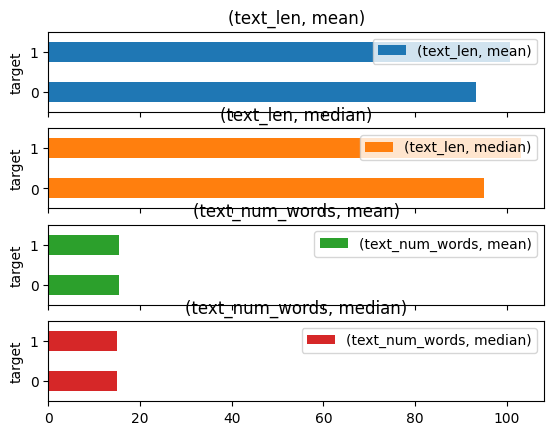

In [12]:
train_df[['target', 'text_len', 'text_num_words']].groupby(['target']).agg(['mean', 'median']).plot.barh(subplots = True)

Here I combine all Tweets, based on text_clean, into a single list and extract the frequency of each word. The top 15 words are printed below. No surprise this list is topped by predicates and articles.

In [13]:
# Flatted the tweets into a single list of words
train_words_flattened = [word.lower() for text in train_df['text_words'] for word in text]
train_words_series = pd.Series(train_words_flattened).value_counts(normalize = True)

print(f'There are {len(train_words_series)} distinct words/tokens in the training data')

# Get the relative frequency of the top words in the data
top_k_words = 15
print(f'The top {top_k_words} are: ')
train_words_series[0:top_k_words]

There are 16207 distinct words/tokens in the training data
The top 15 are: 


the     0.028072
a       0.019004
in      0.016932
to      0.016632
of      0.015566
i       0.015351
and     0.012188
s       0.008715
is      0.008088
for     0.007650
you     0.007650
on      0.007641
it      0.006618
my      0.005802
that    0.005346
Name: proportion, dtype: float64

# Architecture and Plan

In the model training below I experiment with four models: Three very basic models consisting of an embedding layer, a dropout layer, and a bi-directional RNN layer (either SimpleRNN, LSTM, or GRU), followed by a final classification layer, and a fourth, slightly more complicated, model with additional layers. 

The models are trained on vectorized text, which has been passed through a vectorization layer. This could be considered the true first layer of each model described previously. For this layer I use a TextVectorization layer from Keras, with a vocabularly built using the TfidfVectorizer from scikit-learn. Prior to any of this processing, I split the original training data into train and validation sets. 

Judged by loss, the GRU model, model 3, is the best model; the more complicated GRU model, model 4, does not improve on these results. Through iterative experimentation with different model architectures (e.g., varying depth, shrinking and expanding the embedding, adding dropout, etc.), I saw little gain with more complicated setups. However, I saw a notable drop in accuracy when not using bi-directional layers. That is why the four models below all use bi-directional layers.

Up first, before the data preprocessing steps, I define two helper functions to display training results and construct the models. These save repeating the same cells over again each time I build and train a model. 

In [14]:
def plot_model_fit_history(training_hist, model_name):
    # Create two plots with a shared X-axis
    fig, axs = plt.subplots(2, 1, sharex = True)
    # Remove vertical space between axes
    fig.subplots_adjust(hspace = 0)
    # Plot losses
    axs[0].plot(training_hist.history['loss'])
    axs[0].plot(training_hist.history['val_loss'])
    axs[0].legend(['Train', 'Validation'], loc = 'upper left')
    axs[0].set_ylabel('Loss')
    # Plot accuracy
    axs[1].plot(training_hist.history['accuracy'])
    axs[1].plot(training_hist.history['val_accuracy'])
    axs[1].legend(['Train', 'Validation'], loc = 'upper left')
    axs[1].set_ylabel('Accuracy')
    
    fig.supxlabel('Epoch')
    fig.suptitle(f'Training Loss and Accuracy for {model_name}')
    # Display
    plt.show()

In [15]:
def create_seq_model(embedd_output_dim, hidden_layer_sizes, hidden_layer_types, dense_dim = None, drop_out = None):
    assert len(hidden_layer_sizes) == len(hidden_layer_types), 'Check hidden layer specification'
    # Get the number of hidden layers
    n_hidden = len(hidden_layer_sizes)
    # Create the base model
    model = keras.Sequential()
    # Add the embedding layer
    model.add(layers.Embedding(input_dim = len(vectorizer.vocabulary_.keys()), output_dim = embedd_output_dim))
    model.add(layers.Dropout(0.5))
    # Add the hidden layers
    for layer_ind in range(n_hidden):
        # Determine whether the layer needs to return sequences (i.e., additional layers will be stacked)
        if layer_ind < n_hidden - 1:
            return_sequences = True
        else:
            return_sequences = False
        # Add the layer
        if hidden_layer_types[layer_ind] == 'RNN':
            model.add(layers.Bidirectional(layers.SimpleRNN(hidden_layer_sizes[layer_ind], return_sequences = return_sequences)))
        elif hidden_layer_types[layer_ind] == 'LSTM':
            model.add(layers.Bidirectional(layers.LSTM(hidden_layer_sizes[layer_ind], return_sequences = return_sequences)))
        elif hidden_layer_types[layer_ind] == 'GRU':
            model.add(layers.Bidirectional(layers.GRU(hidden_layer_sizes[layer_ind], return_sequences = return_sequences)))
        else:
            print('Unrecognized layer - Layer not added to model')
    # Add a dense layer
    if dense_dim != None:
        model.add(layers.Dense(dense_dim, activation = 'relu'))
    # Add a dropout
    if drop_out != None:
        model.add(layers.Dropout(drop_out))
    # Add the classification layer
    model.add(layers.Dense(1, activation = 'sigmoid'))
    # Summarize the model
    model.summary()
    # Return the model
    return model

Split the training data into train and validation data. This will allow out-of-sample validation during model training.

In [16]:
X_train, X_val, y_train, y_val = train_test_split(train_df, train_df['target'], test_size = 0.20, random_state = 123)
print(f'X_train shape \t{X_train.shape}')
print(f'X_val shape \t{X_val.shape}')

X_train shape 	(6048, 11)
X_val shape 	(1513, 11)


Here I create the vocabulary from the training data. This will be fed into the vectorization layer. I chose to use the scikit-learn vectorizer because I have more familiarity with the functionality and like the options available.

The vocabulary building was something I revisited several times while building these models. I tried versions with stop words removed, versions with stronger restrictions on the minimum required frequency and versions with no restrictions, and versions with various ngram ranges. These various configurations, surprisingly, had little impact on the final model results. The setup below, with accent removal, and minimum word occurrance of 2 Tweets, gave good results.

In [105]:
# Create a vectorizer
vectorizer = TfidfVectorizer(strip_accents = 'ascii', min_df = 3, stop_words = 'english')

vectorizer.fit(X_train['text_clean'])

print(f'There are {len(vectorizer.vocabulary_.keys())} words in the vocabulary')
print(f'There are {len(list(vectorizer.stop_words_))} words in the stop words set\n')
print('Vocabulary sample:\n', vectorizer.get_feature_names_out()[0:20])
print('Stop word sample:\n', list(vectorizer.stop_words_)[0:20])

There are 3458 words in the vocabulary
There are 10374 words in the stop words set

Vocabulary sample:
 ['aba' 'abandon' 'abandoned' 'abbott' 'abc' 'abcnews' 'abe' 'ability'
 'ablaze' 'able' 'abomination' 'absolutely' 'abstorm' 'abuse' 'abused'
 'access' 'accident' 'accidentally' 'accidents' 'according']
Stop word sample:
 ['womengirls', 'wednes', 'matching', 'thrarchives', 'sales', 'toddstarnes', 'blockchain', 'delmont', 'diyala', 'grayed', 'sizygwwf', 'bigperm', 'backlash', 'dante', 'sl', 'pozarmy', 'ptsdchat', 'plumbing', 'households', 'insubcontinent']


In [106]:
print(sorted(list(vectorizer.vocabulary_.keys())))

['aba', 'abandon', 'abandoned', 'abbott', 'abc', 'abcnews', 'abe', 'ability', 'ablaze', 'able', 'abomination', 'absolutely', 'abstorm', 'abuse', 'abused', 'access', 'accident', 'accidentally', 'accidents', 'according', 'account', 'acid', 'acres', 'act', 'action', 'actions', 'activated', 'activates', 'active', 'activity', 'acts', 'actual', 'actually', 'ad', 'add', 'added', 'adding', 'address', 'admits', 'adult', 'advisory', 'af', 'affected', 'affecting', 'afghan', 'afghanistan', 'afp', 'afraid', 'africa', 'afterlife', 'afternoon', 'aftershock', 'ag', 'age', 'agents', 'ages', 'ago', 'agree', 'agreed', 'ah', 'ahead', 'ahh', 'aid', 'aim', 'ain', 'air', 'aircraft', 'airlines', 'airplane', 'airport', 'aka', 'al', 'alabama', 'alarm', 'alarms', 'alaska', 'alberta', 'album', 'alcohol', 'alert', 'alex', 'alive', 'allah', 'alleged', 'allow', 'allowed', 'allows', 'alps', 'alright', 'amazing', 'amazon', 'ambulance', 'america', 'american', 'americans', 'amid', 'amirite', 'amp', 'amsterdam', 'anchora

Use the vocabulary to build the vectorization layer and pass the training and validation data through to vectorize the data for training. 

Here the vectorizer strips punctuation and converts words to lowercase (although this is redudant here), splits on white space, and outputs a numeric vector for each Tweet. The vector values are integer indices corresponding to the word at that position in the Tweet (why we have to supply a vocabulary). This is why these vectorized Tweets are then passed through an embedding layer, as each is really of a higher dimension than the dimension of the vector.

In [107]:
# Create an alternate vectorize_layer using the vocab from the TFIDF vectorizer
vectorize_layer = TextVectorization(standardize = 'lower_and_strip_punctuation',
                                    split = 'whitespace',
                                    vocabulary = list(vectorizer.vocabulary_.keys()),
                                    output_mode = 'int',
                                   )
# Vectorize the training data
train_ds = vectorize_layer(X_train.text_clean)
val_ds = vectorize_layer(X_val.text_clean)

The final step before training is to batch and prefetch the data. This will make training more efficient.

In [108]:
batch_size = 16
train_ds = tf.data.Dataset.from_tensor_slices((train_ds, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_ds, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Model Training


In [109]:
# Define an early stopper callback 
earl_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'min')

In [110]:
tf.keras.backend.clear_session()

### Model 1
This is quite a simple model: Vectorization, embedding, dropout, a SimpleRNN, and finally a classifier.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          110656    
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 32)               1568      
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 112,257
Trainable params: 112,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
378/378 - 33s - loss: 0.6858 - accuracy: 0.5628 - val_loss: 0.6743 - val_accuracy: 0.5790 - 33s/epoch - 

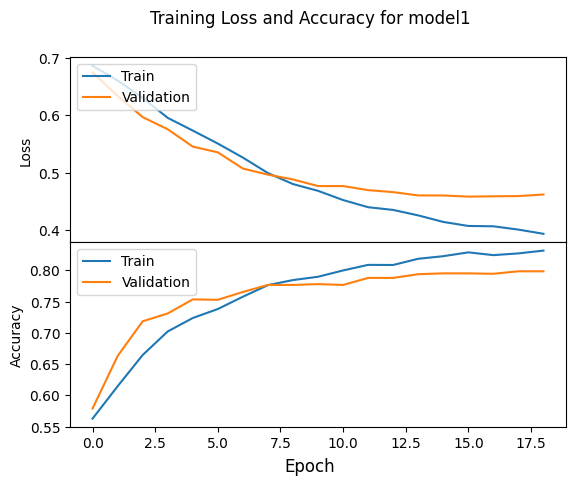

In [111]:
# Build a single-layer RNN model
model1 = create_seq_model(32, [16], ['RNN'])
model1.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.RMSprop(1e-4), metrics = ['accuracy'])
# Fit the model and display the results 
model_hist = model1.fit(x = train_ds, epochs = 100, validation_data = val_ds, callbacks = [earl_stop], verbose = 2)
# Display the training results
plot_model_fit_history(model_hist, 'model1')

### Model 2
The only difference from the previous model is that the bi-directional layer will be an LSTM.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          110656    
                                                                 
 dropout_1 (Dropout)         (None, None, 32)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 116,961
Trainable params: 116,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
378/378 - 11s - loss: 0.6810 - accuracy: 0.5734 - val_loss: 0.6771 - val_accuracy: 0.5677 - 11s/epoch 

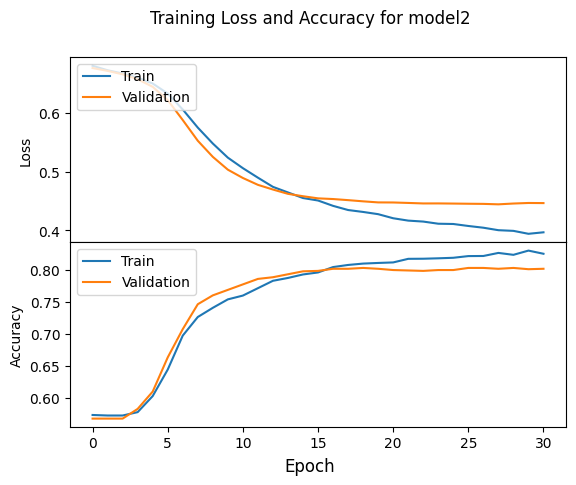

In [112]:
# Build a single-layer LSTM model
model2 = create_seq_model(32, [16], ['LSTM'])
model2.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.RMSprop(1e-4), metrics = ['accuracy'])
# Fit the model and display the results 
model_hist = model2.fit(x = train_ds, epochs = 100, validation_data = val_ds, callbacks = [earl_stop], verbose = 2)
# Display the training results
plot_model_fit_history(model_hist, 'model2')

### Model 3
Similar to the prior model, I make a small change to model 1 and use a GRU in the bi-directional layer.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          110656    
                                                                 
 dropout_2 (Dropout)         (None, None, 32)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               4800      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 115,489
Trainable params: 115,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
378/378 - 11s - loss: 0.6836 - accuracy: 0.5757 - val_loss: 0.6800 - val_accuracy: 0.5677 - 11s/epoch 

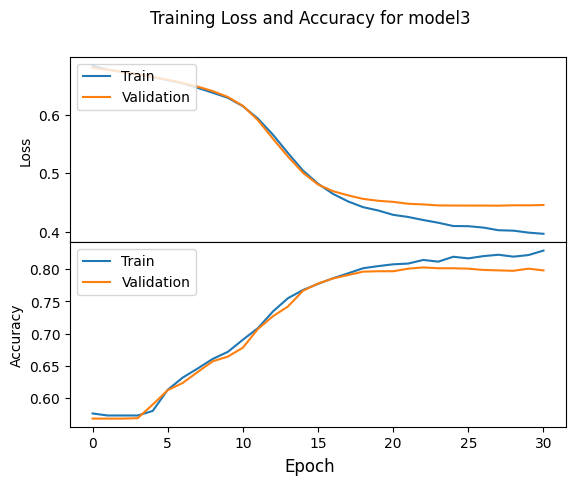

In [113]:
# Build a single-layer GRU model
model3 = create_seq_model(32, [16], ['GRU'])
model3.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.RMSprop(1e-4), metrics = ['accuracy'])
# Fit the model and display the results 
model_hist = model3.fit(x = train_ds, epochs = 100, validation_data = val_ds, callbacks = [earl_stop], verbose = 2)
# Display the training results
plot_model_fit_history(model_hist, 'model3')

Now I evaluate each of the three models on the validation set. This is the same as what is displayed above in the training charts, but it allows a more direct comparison. Based on these results I see model 3, which used a GRU, as the winner.

In [114]:
results = model1.evaluate(val_ds, verbose = 0)
print(f'model1 validation loss and accuracy: {round(results[0], 4)}, {round(results[1], 4)}')
results = model2.evaluate(val_ds, verbose = 0)
print(f'model2 validation loss and accuracy: {round(results[0], 4)}, {round(results[1], 4)}')
results = model3.evaluate(val_ds, verbose = 0)
print(f'model3 validation loss and accuracy: {round(results[0], 4)}, {round(results[1], 4)}')

model1 validation loss and accuracy: 0.4619, 0.7984
model2 validation loss and accuracy: 0.4467, 0.8024
model3 validation loss and accuracy: 0.4457, 0.7984


### Model 4
Increasing the complexity somewhat, I add an additional GRU layer to model 3. The results from the validation set suggest little, if any, improvement over models 1-3.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          110656    
                                                                 
 dropout_3 (Dropout)         (None, None, 32)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 64)         12672     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 32)               7872      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 131,233
Trainable params: 131,233
Non-tr

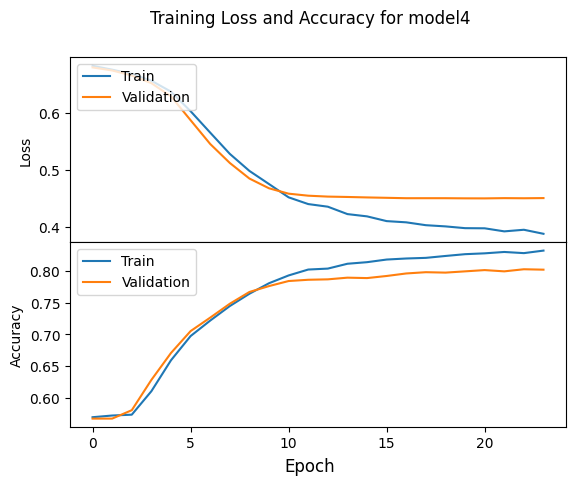

In [115]:
model4 = create_seq_model(32, [32, 16], ['GRU']*2)
model4.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.RMSprop(1e-4), metrics = ['accuracy'])
# Fit the model and display the results 
model_hist = model4.fit(x = train_ds, epochs = 100, validation_data = val_ds, callbacks = [earl_stop], verbose = 0)
# Display the training results
plot_model_fit_history(model_hist, 'model4')

In [116]:
results = model4.evaluate(val_ds, verbose = 0)
print(f'model4 validation loss and accuracy: {round(results[0], 4)}, {round(results[1], 4)}')

model4 validation loss and accuracy: 0.4511, 0.8017


# Analysis and Conclusion
These relatively simple models, each constructed with Keras in only a few lines, demonstrated good generalization ability in the task of classifying the out-of-sample Tweets. To summarize, after reading in the data and performing some basic preprocessing (removing URLs, stripping non-alphabetic characters, adding keywords), I built a vocabulary from the training data and vectorized the text before feeding the data into a variety of recurrent neural networks. 

In the course of this project, I performed extensive testing and experimentation in the construction of the vocabulary, the architecture of the models, and the selection of hyperparameters (e.g., the Adam optimizer performed poorly and learning rate schedules consistently broke in training), and could not meaningfully surpass the performance of the most basic models (models 1-3). I would like to revisit a similar problem with a larger training set, as I suspect these techniques tended to overfit due to the relative lack of sample data with which to train.

## Resources

The tutorials and documentation below were very helpful in approaching this problem.

* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
* https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices
* https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
* https://www.tensorflow.org/text/tutorials/text_classification_rnn
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

## Submission

In [117]:
# Clean up the test Tweets
clean_tweet_text(test_df)
# Vectorize
test_ds = vectorize_layer(test_df.text_clean)


There are 1731 Tweets containing a URL; 1731 were cleaned
There are 313 Tweets containing a URL; 313 were cleaned
There are 12 Tweets containing a URL; 12 were cleaned
There are 1 Tweets containing a URL; 1 were cleaned

All URLs are removed.

Before and after for Tweet at index 18:
	Original Tweet:	 Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw
	Cleaned Tweet:	 Check these out:     #nsfw


In [118]:
test_df['model1'] = np.round(model1.predict(test_ds)).astype('int')
test_df['model2'] = np.round(model2.predict(test_ds)).astype('int')
test_df['model3'] = np.round(model3.predict(test_ds)).astype('int')
test_df['model4'] = np.round(model4.predict(test_ds)).astype('int')

102/102 [==============================] - 1s 4ms/step


In [119]:
models = 4
for i in range(models):
    model = 'model' + str(i+1)
    preds_df = test_df[['id', model]]
    preds_df.columns = ['id', 'target']
    submission_name = 'submission' + model + '.csv'
    preds_df.to_csv(submission_name, index = False)